##**Equipo FacePhi Challenge 2022**: bitblayde

#Carga de datos

Para la carga de datos se han usado las funciones originales del fichero`FacePhiChallenge_Baseline.ipynb`

In [ ]:
#%rm -rf data

In [ ]:
import os
import tqdm
import argparse
from urllib.request import urlretrieve
import tarfile
import zipfile
import os
import tensorflow as tf

midv500_links = [
    "ftp://smartengines.com/midv-500/dataset/01_alb_id.zip",
    "ftp://smartengines.com/midv-500/dataset/05_aze_passport.zip",
    "ftp://smartengines.com/midv-500/dataset/21_esp_id_old.zip",
    "ftp://smartengines.com/midv-500/dataset/22_est_id.zip",
    "ftp://smartengines.com/midv-500/dataset/24_fin_id.zip",
    "ftp://smartengines.com/midv-500/dataset/25_grc_passport.zip",
    "ftp://smartengines.com/midv-500/dataset/32_lva_passport.zip",
    "ftp://smartengines.com/midv-500/dataset/39_rus_internalpassport.zip",
    "ftp://smartengines.com/midv-500/dataset/41_srb_passport.zip",
    "ftp://smartengines.com/midv-500/dataset/42_svk_id.zip",
]

midv2019_links = [
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/01_alb_id.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/05_aze_passport.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/21_esp_id_old.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/22_est_id.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/24_fin_id.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/25_grc_passport.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/32_lva_passport.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/39_rus_internalpassport.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/41_srb_passport.zip",
    "ftp://smartengines.com/midv-500/extra/midv-2019/dataset/42_svk_id.zip",
]

midv2020_links = ["ftp://smartengines.com//midv-2020/dataset/photo.tar"]

def extract(path):
    out_path, extension = os.path.splitext(path)

    if extension == ".tar":
        with tarfile.open(path, "r:") as tar:
            tar.extractall(out_path, )
    elif extension == ".zip":
        with zipfile.ZipFile(path) as zf:
            zf.extractall(out_path)
    else:
        raise NotImplementedError()

class tqdm_upto(tqdm.tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download(url: str, save_dir: str):
    # Creates save_dir if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Downloads the file
    with tqdm_upto(unit="B", unit_scale=True, miniters=1) as t: 
        urlretrieve(
            url,
            filename=os.path.join(save_dir, url.split("/")[-1]),
            reporthook=t.update_to,
            data=None,
        )

def download_and_extract(links_set, download_dir: str = './data'):
    out_path = os.path.join(download_dir)
    for i, link in enumerate(links_set):
        # download zip file
        link = link.replace("\\", "/")
        filename = os.path.basename(link)
        print()
        print(f"Downloading {i+1}/{len(links_set)}:", filename)
        download(link, out_path)

        # unzip zip file
        print("Unzipping:", filename)
        zip_path = os.path.join(out_path, filename)
        extract(zip_path)

        # remove zip file
        os.remove(zip_path)

download_and_extract(midv500_links, download_dir='data/midv500')

In [ ]:
from typing import List, Tuple
import glob
import tqdm
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
plt.rcParams["figure.figsize"] = (20, 16)


classes = [
    "alb_id",
    "aze_passport",
    "esp_id",
    "est_id",
    "fin_id",
    "grc_passport",
    "lva_passport",
    "rus_internalpassport",
    "srb_passport",
    "svk_id",
]

def get_class(*, img_path: str, dataset: str):
    if dataset in ['midv500', 'midv2019']:
        dirname = img_path.split('/')[-4]
        return '_'.join(dirname.split('_')[1:3])
    else:
        dirname = img_path.split('/')[-2]
        return '_'.join(dirname.split('_')[:2])

def get_location(*, loc_path: str):
    return json.load(open(loc_path, 'r'))['quad']

def get_location_path(img_path: str, loc_dirname: str = 'ground_truth'):
    loc_path = img_path.replace('images', loc_dirname)
    loc_path = os.path.splitext(loc_path)[0]+'.json'
    return loc_path

def get_metadata(image_paths: List[str], dataset: str, gt_dirname: str = 'ground_truth'):
    location_paths = [get_location_path(img_path=path, loc_dirname=gt_dirname) for path in image_paths]
    locations = np.stack(
        [get_location(loc_path=path) for path in location_paths],
        axis=0
    )
    class_labels = np.array([get_class(img_path=path, dataset=dataset) for path in image_paths])

    return locations, class_labels

def get_midv500_data(path='data/midv500'):
    image_paths = glob.glob(os.path.join(path, '*', '*', 'images', '*', '*'))
    locations, class_labels = get_metadata(image_paths, dataset='midv500')

    return image_paths, locations, class_labels

def get_midv2019_data(path='data/midv2019'):
    image_paths = glob.glob(os.path.join(path, '*', 'images', '*', '*'))
    locations, class_labels = get_metadata(image_paths, dataset='midv2019')

    return image_paths, locations, class_labels

def get_midv2020_data(path='data/midv2020'):
    gt_paths = glob.glob(os.path.join(path, 'photo', 'annotations', '*.json'))

    class_labels = []
    locations = []
    image_paths = []

    for gt_path in gt_paths:
        json_data = json.load(open(gt_path, 'r'))
        # class_name = json_data['_via_settings']['project']['name']
        class_name = os.path.splitext(os.path.basename(gt_path))[0]
        basedir = os.path.join(path, 'photo', 'images', class_name)

        for k, v in json_data['_via_img_metadata'].items():
            image_paths.append(os.path.join(basedir, v['filename']))
            for reg in v['regions']:
                if reg['shape_attributes']['name'] == 'polygon':
                    x = reg['shape_attributes']['all_points_x']
                    y = reg['shape_attributes']['all_points_y']
                    loc = np.stack([x, y], axis=1)
            locations.append(loc)
            class_labels.append(class_name)

    return image_paths, locations, class_labels

def show_image(image_path: str, location: np.ndarray = None, label: str = None):
    plt.imshow(load_img(image_path))

    if location is not None:
        x, y = location[:, 0], location[:, 1]
        plt.plot(np.append(x, x[0]), np.append(y, y[0]), color=(1, 0, 0), linewidth=2.0)
    if label is not None:
        print(label)
    plt.show()

In [ ]:
def load_img(path: str, size: Tuple[int, int] = None):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    if size is not None:
        img = cv2.resize(img, size)
    return img

def preprocess(
    image_paths: List[str],
    locations: np.ndarray,
    labels: List[str],
    image_size: Tuple[int, int],
    class_names: str = None
):
    if class_names is None:
        unique_labels, label_ids = np.unique(labels, return_inverse=True)
    else:
        unique_labels = class_names
        label_ids = np.array([class_names.index(l) for l in labels])

    images = np.zeros((len(image_paths), image_size[0], image_size[1], 3), dtype=np.uint8)
    for i, path in enumerate(tqdm.tqdm(image_paths)):
        images[i] = load_img(path, size=image_size)

    # Normalize in range (-1, 1)
    images = images.astype(np.float32) / 127.5 - 1.0
    return images, label_ids, unique_labels


input_size = (224, 224)
image_paths, locations, labels = get_midv500_data()
train_images, train_label_ids, unique_labels = preprocess(image_paths, locations, labels, input_size)

100%|██████████| 3000/3000 [02:14<00:00, 22.23it/s]


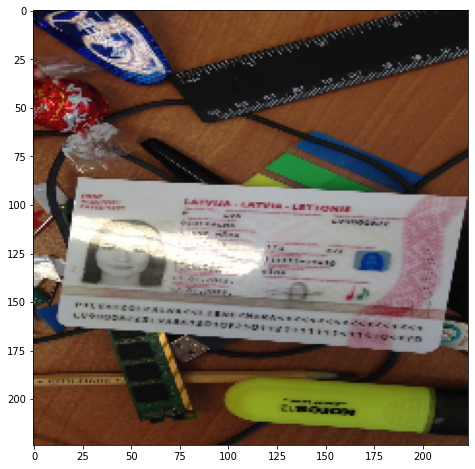

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)

idx = np.random.randint(len(train_images))
img = load_img(image_paths[idx], size=(224, 224))

plt.imshow(img)
plt.show()

Se cargan los datos de test:

In [ ]:
download_and_extract(midv2020_links, download_dir='data/midv2020')

test_image_paths, test_locations, test_labels = get_midv2020_data()

test_images, test_label_ids, _ = preprocess(test_image_paths, test_locations, test_labels, input_size)

100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]


Para conocer si es un problema de clasificación imbalanceada, habría que comprobar el número de observaciones por cada clase

In [ ]:
import collections

collections.Counter(train_label_ids)

Counter({0: 300,
         1: 300,
         2: 300,
         3: 300,
         4: 300,
         5: 300,
         6: 300,
         7: 300,
         8: 300,
         9: 300})

La distribución de observaciones por cada clase parece ser uniforme. Por tanto, no se trata de un problema de clasificación imbalanceada.

Antes de ejecutar los algoritmos, habría que comprobar de qué gráfica se dispone, así como el tamaño de la memoria V-RAM.

In [ ]:
!nvidia-smi

Sun Feb 20 17:16:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Enfoque:
Se trata de un problema de clasificación multinomial. Por ello, al tener 10 clases (distribuidas uniformemente) se tendrá que hacer uso de algoritmos robustos de clasificación.  
  
  En este proyecto en concreto, no tiene sentido usar el criterio "data split" dividiendo los datos de entrenamiento en una partición para entrenar el modelo y otra para validarlo, ya que, los datos de train constituyen capturas de pantalla (o frames) de diversos vídeos. Por tanto, habría filtración de información, ya que los datos usados en train serían los mismos que los de validación, pero con una pequeña traslación o rotación aplicada a la matriz de imagen.  
    
Lo anterior puede comprobarse de forma rápida, al dividir los datos de entrenamiento en las particiones de entrenamiento y validación, y usar un modelo con una exactitud alta (y error bajo) en ambas particiones con el conjunto de test. Con toda probabilidad se tendría un modelo incapaz de generalizar, y por ello presentaría una exactitud baja, y un error alto en test.

## Clasificación

Se usará un tamaño de batch pequeño, ya que, actúa con efecto regularizador (tal como propone [On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima](http://arxiv.org/abs/1609.04836) ), aunque como principal inconveniente, minimice la ventaja del alto paralelismo que las redes convolucionales proporcionan.




#### **Primer enfoque. int Complejidad = 0**

Se crea la primera red y más simple, que servirá como baseline para algoritmos más complejos de deep learning.

- Se usarán dos bloques convolucionales con tamaño de filtro creciente (32, 64)
- La función de activación será la función *relu*
- Se usará el padding de tipo *same* con el fin de escoger el mismo número de columnas, añadiendo 0, en caso de que fuese de tamaño impar.
- Bloques de dropout para "desactivar" algunas unidades para mitigar el posible sobreajuste.
- Una capa fc con 256 unidades
- Capa clasificadora con la función softmax, dado que se trata de un problema de clasificación multinomial

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(train_images, train_label_ids, epochs=40, batch_size=16, shuffle=True)

Epoch 1/40
188/188 [==============================] - 50s 209ms/step - loss: 1.9645 - accuracy: 0.7783
Epoch 2/40
188/188 [==============================] - 39s 206ms/step - loss: 0.0791 - accuracy: 0.9783
Epoch 3/40
188/188 [==============================] - 39s 209ms/step - loss: 0.0318 - accuracy: 0.9907
Epoch 4/40
188/188 [==============================] - 39s 208ms/step - loss: 0.0360 - accuracy: 0.9910
Epoch 5/40
188/188 [==============================] - 40s 211ms/step - loss: 0.0388 - accuracy: 0.9910
Epoch 6/40
188/188 [==============================] - 40s 211ms/step - loss: 0.0490 - accuracy: 0.9860
Epoch 7/40
188/188 [==============================] - 39s 210ms/step - loss: 0.0138 - accuracy: 0.9967
Epoch 8/40
188/188 [==============================] - 39s 209ms/step - loss: 0.0145 - accuracy: 0.9970
Epoch 9/40
188/188 [==============================] - 39s 208ms/step - loss: 0.0084 - accuracy: 0.9957
Epoch 10/40
188/188 [==============================] - 39s 209ms/step - l

In [ ]:
from sklearn.metrics import f1_score

preds = model.predict(test_images, batch_size=16, verbose=1)
preds = np.argmax(preds, axis=-1)

print("MacroF1:", f1_score(y_true=test_label_ids, y_pred=preds, labels=np.arange(10), average='macro'))
print("MicroF1:", f1_score(y_true=test_label_ids, y_pred=preds, labels=np.arange(10), average='micro'))
print("Accuracy ", np.mean(test_label_ids==preds))

63/63 [==============================] - 2s 24ms/step
MacroF1: 0.2772601700011435
MicroF1: 0.303
Accuracy  0.303


El rendimiento de la red, como puede observarse es bastante deficiente, a pesar de que el error de entrenamiento es bastante bajo y la exactitud roza el 100%. Esto indica que la red presenta una alta varianza y por tanto, su error de generalización es elevado en comparación al de entrenamiento. 
Se propondrá una red más robusta para solventar dicho problema. Intentando encontrar un equilibrio entre el sesgo y la varianza.


#### **Segundo enfoque. ++Complejidad**

A continuación, se propone la creación de una red más robusta que la anterior, basada en el modelo Resnet34 [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).


In [ ]:
class Residual_block(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    
    # treating convolutional block as a unique block
    self.conv_block = [
        tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=strides, padding="same", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False),
        tf.keras.layers.BatchNormalization()
    ]
    
    # different shapes?
    self.skip = []
    if strides > 1:
      # adjusting the feature map size
      self.skip.append(tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False))
      self.skip.append(tf.keras.layers.BatchNormalization())


  def call(self, X):
      jmp = X
      for layer in self.conv_block:
          jmp = layer(jmp)
      
      for layer in self.skip:
          X = layer(X)

      # Skip flow
      return self.activation(jmp + X)

class Residual_net(tf.keras.models.Model):
  def __init__(self, filters, activation="relu", input_shape=[224, 224, 3], **kwargs):
    super().__init__(**kwargs)
    self.initial_model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, input_shape=input_shape, padding="SAME", use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),
      tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"),
    ])
    self.residual_blocks = self.build_residual_blocks(filters, activation="relu")
    self.classifier = tf.keras.layers.Dense(10, activation="softmax")

  def build_residual_blocks(self, n_filters, activation):
    residual_block = []
    last_filters = 64

    for filters in n_filters:
      if last_filters == filters:
        strides = 1
      else:
        strides = 2

      residual_block.append(Residual_block(filters, activation=activation, strides=strides))
      last_filters = filters

    return residual_block

  def call(self, X):
    X = self.initial_model(X)
    
    for b in self.residual_blocks:
      X = b(X)

    X = tf.keras.layers.GlobalAvgPool2D()(X)
    X = tf.keras.layers.Flatten()(X)
    
    return self.classifier(X)

tf.keras.backend.clear_session()
model = Residual_net([64] * 3 + [128] * 4 + [256] * 6 + [512] * 3)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(train_images, train_label_ids, epochs=50, shuffle=True, batch_size=16)

Epoch 1/50
188/188 [==============================] - 40s 110ms/step - loss: 1.2105 - accuracy: 0.6547
Epoch 2/50
188/188 [==============================] - 20s 108ms/step - loss: 0.1498 - accuracy: 0.9553
Epoch 3/50
188/188 [==============================] - 20s 109ms/step - loss: 0.1179 - accuracy: 0.9687
Epoch 4/50
188/188 [==============================] - 21s 109ms/step - loss: 0.0605 - accuracy: 0.9807
Epoch 5/50
188/188 [==============================] - 21s 110ms/step - loss: 0.0910 - accuracy: 0.9700
Epoch 6/50
188/188 [==============================] - 21s 110ms/step - loss: 0.0253 - accuracy: 0.9950
Epoch 7/50
188/188 [==============================] - 21s 111ms/step - loss: 0.0236 - accuracy: 0.9950
Epoch 8/50
188/188 [==============================] - 21s 111ms/step - loss: 0.0333 - accuracy: 0.9897
Epoch 9/50
188/188 [==============================] - 21s 111ms/step - loss: 0.0706 - accuracy: 0.9800
Epoch 10/50
188/188 [==============================] - 21s 111ms/step - l

In [ ]:
from sklearn.metrics import f1_score

preds = model.predict(test_images, batch_size=16, verbose=1)
preds = np.argmax(preds, axis=-1)

print("MacroF1:", f1_score(y_true=test_label_ids, y_pred=preds, labels=np.arange(10), average='macro'))
print("MicroF1:", f1_score(y_true=test_label_ids, y_pred=preds, labels=np.arange(10), average='micro'))
print("Accuracy ", np.mean(test_label_ids==preds))

63/63 [==============================] - 2s 29ms/step
MacroF1: 0.40431617014808524
MicroF1: 0.403
Accuracy  0.403


La exactitud con los datos de entrenamiento es del 100%, pero en los datos de test, se tiene una del 40.3% únicamente. Este enfoque presenta un 10% más de exactitud que el primero. Sin embargo, sigue sin ser suficiente.

#### **Tercer enfoque. (++Complejidad)<<1**

Como tercer enfoque, se aboga por la técnica de Transfer Learning (o adaptación del dominio), la cual consiste en usar una red (normalmente compleja) que ya ha sido entrenada en un determinado dominio ([imagenet](https://www.image-net.org/) en este caso), y que, además, ha proporcionado unos resultados competentes. Se usan sus pesos (o mejor conocido de forma poco precisa como el "aprendizaje adquirido") para resolver un problema (usualmente menos complejo) para el que ha sido creada inicialmente. Análogamente, se realizará la técnica de "fine tuning", la cual propiciará que el modelo aprenda específicamente sobre este problema en concreto. Para ello, se congelan *n* capas, es decir, se marcan con el flag `trainable = False`, por tanto, no pueden ser entrenadas. El resto, se marcan con el flag `trainable = True`, y serán las que se "entrenen" en este dominio específico.

La red [**DenseNet201**](http://arxiv.org/abs/1608.06993) consta de 706 capas, sin incluir la capa clasificadora, y una capa previa a esta de tipo pooling usando la media global.

In [ ]:
base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet')
x = base_model.output
 
# Pooling using the global average
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
 
# Classifier layer
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
 
# DenseNet201 model builded
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

# training with all layers remaining freeze
model.fit(train_images, train_label_ids, batch_size=16, epochs=10, shuffle=True)

# Fine tuning some layers. 
for layer in base_model.layers[0:450]:
  layer.trainable = False

for layer in base_model.layers[450:]:
  layer.trainable = True

# The purpose is to reduce overshooting and slowly decrease the learning rate through exponential decay
def scheduler(epoch, lr):
  return lr if epoch < 8 else lr * tf.math.exp(-0.1)

training_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01/10),
              metrics=['accuracy'])

hist = model.fit(train_images, train_label_ids, batch_size=16, epochs=30, shuffle=True, callbacks=training_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
188/188 [==============================] - 26s 90ms/step - loss: 0.4652 - acc: 0.8790
Epoch 2/10
188/188 [==============================] - 17s 91ms/step - loss: 0.0128 - acc: 0.9993
Epoch 3/10
188/188 [==============================] - 17s 91ms/step - loss: 0.0039 - acc: 1.0000
Epoch 4/10
188/188 [==============================] - 17s 92ms/step - loss: 0.0022 - acc: 1.0000
Epoch 5/10
188/188 [==============================] - 17s 91ms/step - loss: 0.0014 - acc: 1.0000
Epoch 6/10
188/188 [==============================] - 17s 92ms/step - loss: 0.0010 - acc: 1.0000
Epoch 7/10
188/188 [==============================] - 17s 92ms/step - loss: 7.3781e-04 - acc: 1.0000
Epoch 8/10
188/188 [==============================] - 18s 93ms/step - loss: 5.6007e-04 - acc: 1.0000
Epoch 9/10
188/188 [==============================] - 17s 93ms/step - loss: 4.1084e-04 - acc: 1.0000
Epoch 10/10
188/188 [==============================] - 18s 93ms/step - loss: 3.2892e-04 - acc: 1.0000
Epoch 1/30
18

In [ ]:
from sklearn.metrics import f1_score

preds = model.predict(test_images, batch_size=16, verbose=1)
preds = np.argmax(preds, axis=-1)

print(np.mean(preds==test_label_ids))
print("MacroF1:", f1_score(y_true=test_label_ids, y_pred=preds, labels=np.arange(10), average='macro'))
print("MicroF1:", f1_score(y_true=test_label_ids, y_pred=preds, labels=np.arange(10), average='micro'))

63/63 [==============================] - 8s 82ms/step
0.863
MacroF1: 0.8394873674792878
MicroF1: 0.863


# Resultados

In [ ]:
model.save_weights("densenet_model.h5")

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_label_ids, preds)
cm

array([[ 97,   0,   0,   0,   0,   0,   3,   0,   0,   0],
       [  0,  93,   0,   0,   1,   1,   3,   0,   0,   2],
       [  0,   0,  90,   1,   3,   0,   5,   0,   0,   1],
       [ 20,   2,   0,  16,  19,   7,  17,   0,   1,  18],
       [  0,   0,   0,   0,  98,   0,   2,   0,   0,   0],
       [  1,   1,   1,   0,   0,  96,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 100,   0,   0,   0],
       [  2,   0,   0,   0,   0,  10,   2,  85,   1,   0],
       [  0,   0,   0,   0,   0,   2,   4,   1,  93,   0],
       [  0,   0,   0,   0,   3,   0,   2,   0,   0,  95]])

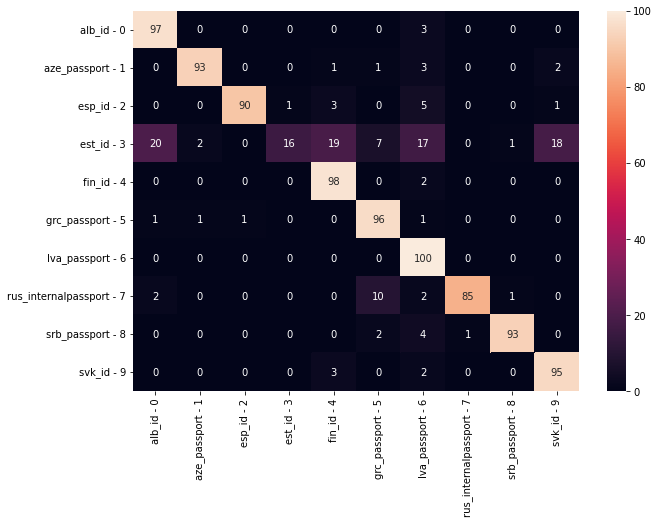

In [ ]:
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(cm, index = [str(i) + ' - ' + str(j) for i, j in zip(classes, np.unique(test_label_ids)) ],
                  columns = [str(i) + ' - ' + str(j) for i, j in zip(classes, np.unique(test_label_ids)) ])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_label_ids, preds, target_names=classes))

                      precision    recall  f1-score   support

              alb_id       0.81      0.97      0.88       100
        aze_passport       0.97      0.93      0.95       100
              esp_id       0.99      0.90      0.94       100
              est_id       0.94      0.16      0.27       100
              fin_id       0.79      0.98      0.87       100
        grc_passport       0.83      0.96      0.89       100
        lva_passport       0.72      1.00      0.84       100
rus_internalpassport       0.99      0.85      0.91       100
        srb_passport       0.98      0.93      0.95       100
              svk_id       0.82      0.95      0.88       100

            accuracy                           0.86      1000
           macro avg       0.88      0.86      0.84      1000
        weighted avg       0.88      0.86      0.84      1000



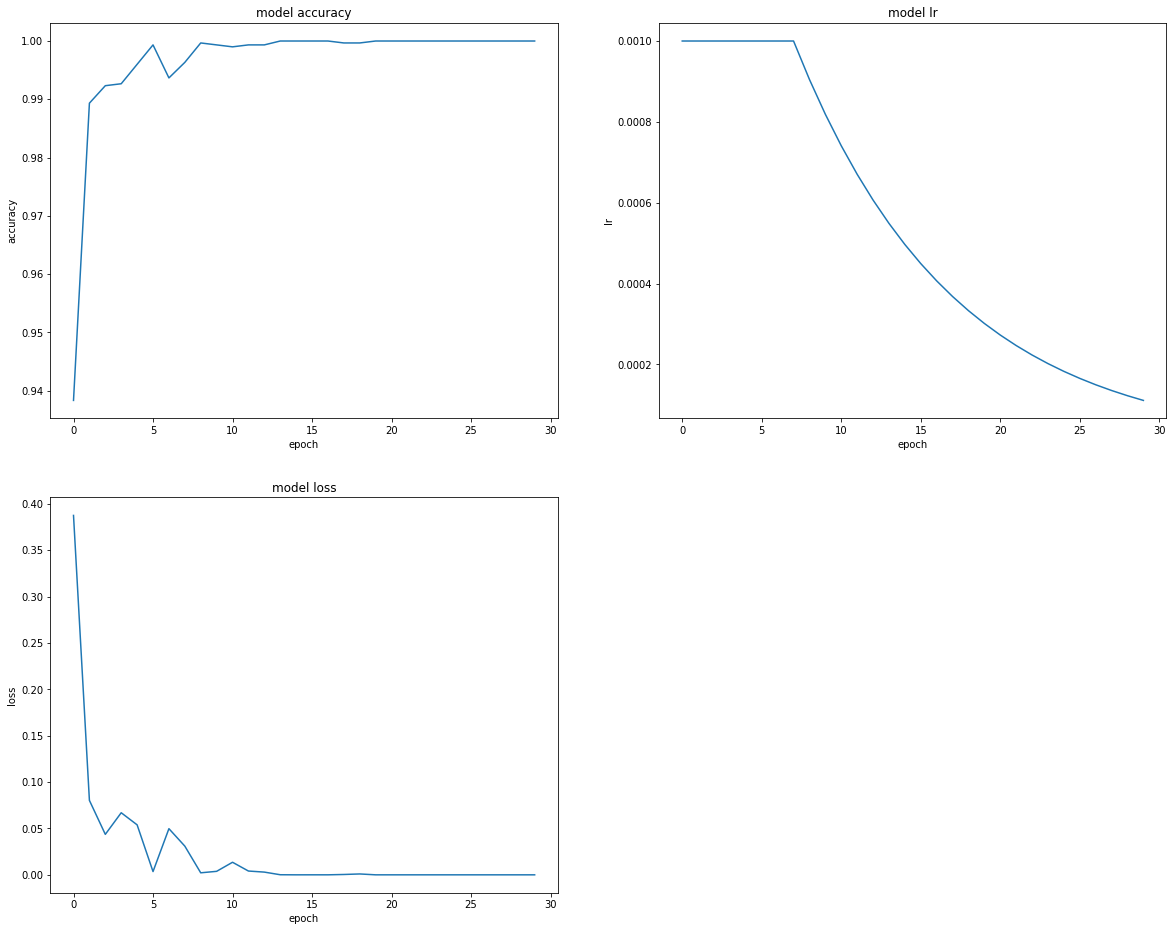

In [ ]:
def plot_hist(field: str) -> None:
  plt.plot(hist.history[field])
  plt.title('model {}'.format(field))
  plt.ylabel(field)
  plt.xlabel('epoch')


plt.subplot(2, 2, 1)
plot_hist("accuracy")
plt.subplot(2, 2, 2)
plot_hist("lr")
plt.subplot(2, 2, 3)
plot_hist("loss")
plt.show()

|Model|Test accuracy|Test macro F1|
|-----|-------------|-------------|
|naive|30.3%|27.7%|
|Resnet-34|40.3%|40.4%|
|DenseNet-201|86.3%|83.9%|

El algoritmo tiene problemas a la hora de distinguir entre documentos de Estonia y otros paises, especialmente Albania y Finlandia. Esto se debe principalmente a que, los documentos en esos tres paises son de un color muy similar (azul cielo). Ya que, por ejemplo, el de Rusia es rosa claro y blanco, y con él no presenta dificultades el algoritmo durante la discriminación. El de Grecia es también rosa claro y blanco, y el algoritmo confunde 10 observaciones entre Grecia y Rusia. Esto podría indicar que los colores juegan un papel fundamental a la hora aprender a discriminar entre los pasaportes de diferentes países.

## ¿Mejoras?

- Una mejora, sin duda la más obvia, podría ser la de crear arquitecturas más robustas y complejas.

- Uso de redes tipo fcn, o autoencoders para así de comprender la representación del mapa de características según la red, en el espacio latente, con el propósito de poder entender y potenciar la capacidad discriminativa de la misma.

- Ampliar el tamaño muestral haciendo uso de más datos reales, o bien generados de forma sintética mediante DCGANS.

- Podría ser interesante entrenar los algoritmos directamente con los vídeos, es decir, con la secuencia de n imágenes de cada vídeo, usando por ejemplo, una red de tipo LSTM o Transformer. De esta forma se podría mitigar, en parte, uno de los grandes inconvenientes, que es, los frames en los que, o bien por el brillo, o bien por un movimiento rápido de la cámara, se tienen imágenes de muy poca calidad (o muy saturadas por el brillo).

## ¿Limitaciones?

- Una de las limitaciones más obvias es la temporalidad, ya que, debido a la falta de tiempo que tenía y que he tenido que afrontar este trabajo durante el curso yo solo, no he dispuesto del tiempo suficiente como para poder abarcarlo de la forma que a mi me habría gustado.

- El entorno de desarrollo, ya que al usar la versión gratuita de GPU con Colab, se me reiniciaba el mismo con cada nuevo modelo que creaba (y ejecutaba). También, cada n minutos debía meterme otra vez en la plataforma, porque si no, se cerraba la sesión. Además del tiempo límite de uso de GPU.



# Bonus.
Se podría mejorar la calidad de los datos de entrenamiento con el propósito de compactar la información y preservar aquella con mayor relevancia reduciendo la dimensionalidad de la imagen. Para ello se pueden usar técnicas de visión por computador clásicas, como la siguiente:

1. Se reduce el tamaño de la imagen y se pasa a escala de grises.  
2. Se le pasa un filtro gaussiano a la imagen con el fin de reducir el ruido de la misma, y que el algoritmo Canny no se vea "intoxicado", perjudicando a subprocesos del mismo, como la histéresis.  
3. Se obtienen aquellos contornos más relevantes a partir del algoritmo Canny.  
4. Se usa el algoritmo de Douglas Peucker para aproximar el contorno a otro "más simple".
5. Se dibujan los contornos en la imagen original tras aplicar el paso 1.


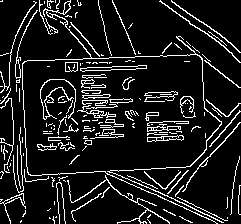

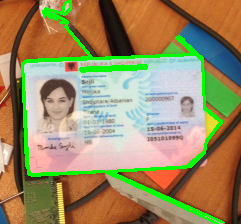

In [ ]:
from google.colab.patches import cv2_imshow
import imutils

img = cv2.imread("./data/midv500/01_alb_id/01_alb_id/images/CA/CA01_01.tif")

# remove irrelevants parts
img = img[400:1400, 0:1080,]

# resize 
img = imutils.resize(img, height = 224)

original_image = img.copy()

# To grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# To avoid noise
img = cv2.GaussianBlur(img, (3, 3), 0)

# Finding contours through Canny algorithm
img = cv2.Canny(img, 80, 100)

cv2_imshow(img)

# Getting contours
contours = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours)==2 else contours[1]
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

total_contours = []
for contour in contours:
  # getting contours approximation using Douglas Peucker 
  peri = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.001 * peri, True)
  
  if len(approx) >= 4:
    screenCnt = approx
    total_contours.append(approx)

cv2.drawContours(original_image, total_contours, -1, (0, 255, 0), 2)
cv2_imshow(original_image)

Si bien es cierto, podrían usarse técnicas de detección más "modernas" como las redes FCN (Fully Convolutional Network) como por ejemplo yolo-v*, o bien mediante redes basadas en regiones, como la conocida Faster rcnn. Y extraer los dni (o pasaportes) de las imágenes, contruyendo con ellos, un dataset "limpio" que será el input de redes como las propuestas aquí.

## References
```{bibliography}
author: Nitish Shirish Keskar and Dheevatsa Mudigere and Jorge Nocedal and Mikhail Smelyanskiy and Ping Tak Peter Tang.
title: On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima
year: 2016
url: http://arxiv.org/abs/1609.04836
```
```{bibliography}
author = Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun,
title = Deep Residual Learning for Image Recognition, 
year = 2015,
url = https://arxiv.org/abs/1512.03385

```

```{bibliography}
author    = Gao Huang and Zhuang Liu and Kilian Q. Weinberger
title     = Densely Connected Convolutional Networks
year      = 2016
url       = http://arxiv.org/abs/1608.06993
```